# Filtering the attributes

- Filtering is done on basis of sparsity, i.e. all the features/attributes are removed whose average Number of 1's is < 1%
- After filtering we found a total of 112 remaining attributes
- Model is trained for these remaining attributes and the results are analysed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random

In [2]:
import tensorflow as tf

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
RGB_IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

TRAIN_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_train_split/whole_resize'
TEST_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_eval_img_resize/'

In [4]:
keras = tf.keras

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import classification_report

def pre_rec(tup):
    """
    Returns a tuple of (precision, recall) for a given input of (tp, tn, fp, fn)
    @param tup - A tuple of (tp, tn, fp, fn)
    """
    tp, tn, fp, fn = tup
    precision = 0.0
    recall = 0.0
    try:
        precision = tp/(tp+fp)
    except ZeroDivisionError:
        precision = np.nan
    
    try:
        recall = tp/(tp+fn)
    except ZeroDivisionError:
        recall = np.nan
        
    return (precision, recall)

def categorize_actual_preds(actuals, preds, threshold=0.5):
    """
    Find the tp, tn, fp, fn for a model with a given threshold
    @param actuals
    @param preds
    @param threshold - default = 0.5
    """
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    #print(actuals.shape)
    if actuals.size != preds.size:
        print("Shapes of actuals and preds not equal")
        return tp, tn, fp, fn
    if np.count_nonzero(actuals) == 0:
        #print("[WARNING] No positive predictions")
        return tp, tn, fp, fn
    
    if actuals.ndim == 2:
        actuals = np.squeeze(actuals, axis=0)
        preds = np.squeeze(preds, axis=0)

    true_indices = []
    false_indices = []
    for i, val in enumerate(actuals):
        if val:
            true_indices.append(i)
        else:
            false_indices.append(i)

    # Calculate tp and fn
    for i in true_indices:
        act = actuals[i]
        pred = preds[i]
        if pred >= threshold:
            tp += 1
        else:
            fn += 1

    # Calculate tn and fp
    for i in false_indices:
        pred = preds[i]
        if pred >= threshold:
            fp += 1
        else:
            tn += 1

    return (tp, tn, fp, fn)

def roc_curve_for_model(actuals, preds):
    plt.figure(figsize=(12,12))
    #for i in range(20):
    fpr, tpr, thres = roc_curve(actuals.flatten(), preds.flatten(), drop_intermediate=False)
    plt.plot(fpr, tpr, marker='.',label="ROC")
    #plt.plot(thres, marker="o")
    plt.plot([0, 1], ls="--", label="No Skill")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
def roc_comparison(model_preds, actuals, model_names=[]):
    """
    Compares the ROC for several models
    :param model_preds: A list of predicted values of several models
    :param actuals: The true_labels which is common for all models since the models are predicted on same dataset
    
    :return: a comparison plot
    """
    plt.figure(figsize=(12,12))
    for i, preds in enumerate(model_preds):
        fpr, tpr, thres = roc_curve(actuals.flatten(), preds.flatten(), drop_intermediate=False)
        auc_ = auc(fpr,tpr)
        if model_names:
            label = model_names[i]
        else:
            label = "ROC_model_"+str(i+1)
        label = f"{label} (area = {auc_})"
        plt.plot(fpr, tpr,label=label)
    #plt.plot(thres, marker="o")
    plt.plot([0, 1], ls="--", label="No Skill")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_roc_for_feature_id(ids, actuals, preds, feature_id_to_name_map=None):
    """
    Plots the roc graph for multiple input feature ids
    @param ids: int, tuple or list of feature ids
    @actuals: list of true labels
    @preds: list of predicted labels
    @feature_id_to_map_map: dictionary of feature_id to feature_name mapping
    """
    loop = []
    if isinstance(ids, int):
        loop = range(ids)
    elif isinstance(ids, tuple):
        low = min(ids[0], ids[1])
        high = max(ids[0], ids[1])
        loop = range(low, high)
    elif isinstance(ids, list):
        loop = ids
    plt.figure(figsize=(12,12))
    for i in loop:
        fpr, tpr, thres = roc_curve(actuals[:,i], preds[:,i], drop_intermediate=False)
        if feature_id_to_name_map:
            label=feature_id_to_name_map.get(i)+"("+str(i)+")"
        else:
            label = str(i)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], ls="--", label="No Skills")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()
    
def result_classifications(actuals, preds, threshold=0.5):
    """
    @return: returns a dict of feature_id to a tuple of (tp, tn, fp, fn)
    """
    classifications = dict()
    #true_labels = test_gen.labels
    for i in range(preds.shape[1]):
        classifications[i] = categorize_actual_preds(actuals[:,i], preds[:,i], threshold=threshold)
        
    return classifications

def calculate_pres_recall(actuals, preds, classifications=None, threshold=0.5):
    precision_recall_report = dict()
    if not classifications:
        classifications = result_classifications(actuals, preds, threshold=threshold)
    for i in classifications.keys():
        precision_recall_report[i] = pre_rec(classifications[i])
        
    return precision_recall_report

In [6]:
def read_list_from_disk(filename, directory="."):
    plist = []
    if not os.path.exists(filename):
        print(f"File path not found: {filename}\n List could not be retrieved")
    with open(filename, 'r') as filehandle:
        for line in filehandle:
            # remove linebreak which is the last character of the string
            l = line[:-1]
            plist.append(l)

    return plist

### Load train and test df

In [7]:
training_df = pd.read_csv('attributes_training_df.csv', index_col='index')
testing_df = pd.read_csv('attributes_testing_df.csv', index_col='index')

In [8]:
features = read_list_from_disk('filtered_features.txt')

### Data generators

In [9]:
data_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
label_columns = read_list_from_disk('filtered_features.txt')

In [11]:
test_gen = data_gen.flow_from_dataframe(testing_df,directory=TEST_IMAGE_PATH, batch_size=32, shuffle=False,
                                        x_col='filename', y_col=label_columns, class_mode='other', 
                                        target_size=IMAGE_SIZE)

Found 11453 validated image filenames.


In [12]:
def show_images_by_features(feature, df, num_images=12, from_df="training", rand=True):
    cols = 5
    rows = int(np.ceil(num_images/cols))
    print(f"Feature: {feature}")
    filtered = df[(df[feature] != 0.0)]['filename'].head(num_images).values
    #filtered.reset_index()
    #random.randint()
    #if rand:
        
    if from_df == "training":
        DIR=TRAIN_IMAGE_PATH
    else:
        DIR=TEST_IMAGE_PATH
    plt.figure(figsize=(15,15))
    #plt.tight_layout(pad=None)
    plt.autoscale()
    plt.title(f"Feature: {feature}")
    i = 0
    for i in range(len(filtered)):
        #for col in range(cols):
        if i < len(filtered):
            plt.subplot(rows,cols, i+1)
            #plt.figure(figsize=(5,5))
            image_path = os.path.join(DIR, filtered[i])
            im = tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
            plt.imshow(im, aspect="auto", interpolation="nearest")
            plt.axis('off')
    plt.show()
        
    #print(filtered)

Feature: Fitness Regular


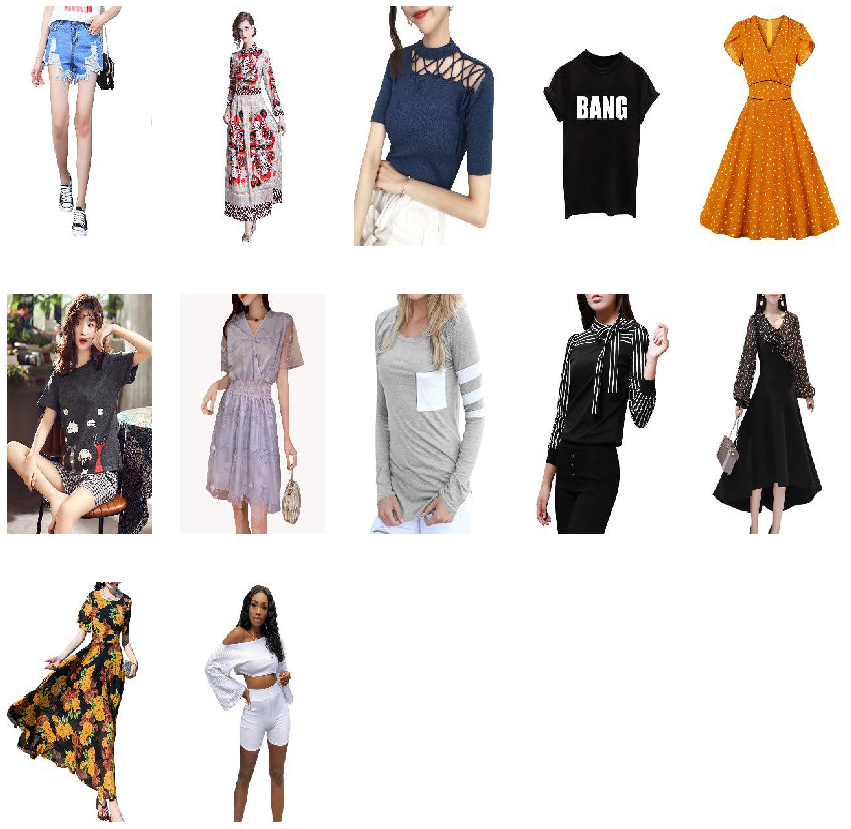

In [13]:
show_images_by_features(features[33], training_df)

### Compare history of various trained models

In [15]:
import json

In [16]:
history_1 = open('filtered_attributes_1_history_2020_02_25_18_12_06.json').read()
history_1 = dict(eval(json.loads(history_1)))

In [17]:
history_2 = open('filtered_attributes_2_b_history_2020_02_26_13_18_50.json').read()
history_2 = dict(eval(json.loads(history_2)))

In [18]:
history_3 = open('filtered_attributes_2_b_history_2020_02_27_12_14_37.json').read()
history_3 = dict(eval(json.loads(history_3)))

In [19]:
history_5 = open('filtered_attributes_6_b_r_d_history_2020_02_28_12_54_21.json').read()
history_5 = dict(eval(json.loads(history_5)))

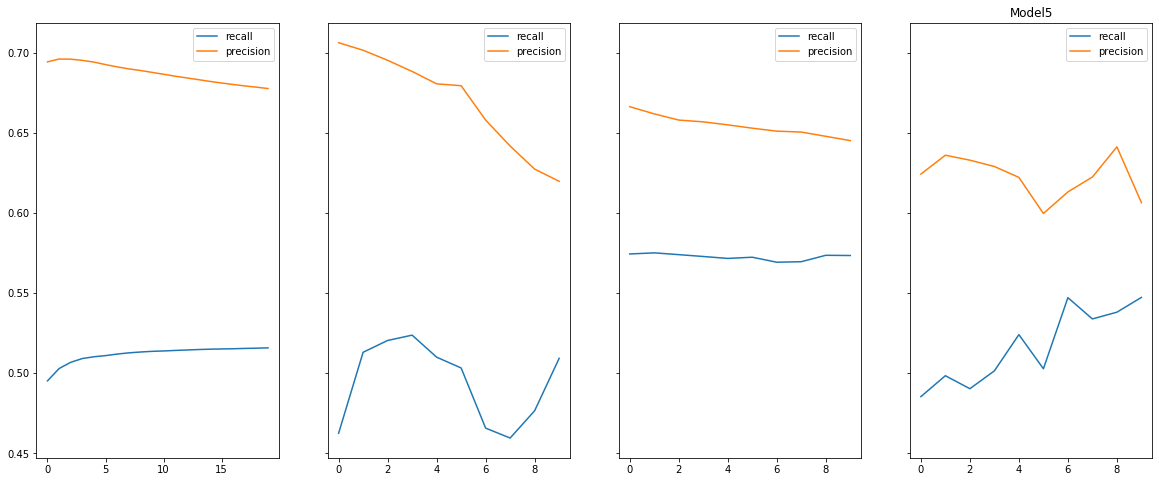

In [20]:
fig, axes = plt.subplots(1,4, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(20)
#plt.plot()
axes[0].plot(history_1['val_recall'], label="recall")
axes[0].plot(history_1['val_precision'], label="precision")
axes[0].legend()
axes[1].plot(history_2['val_recall'], label="recall")
axes[1].plot(history_2['val_precision'], label="precision")
axes[1].legend()
axes[2].plot(history_3['val_recall'], label="recall")
axes[2].plot(history_3['val_precision'], label="precision")
axes[2].legend()
axes[3].plot(history_5['val_recall'], label="recall")
axes[3].plot(history_5['val_precision'], label="precision")
axes[3].legend()
axes[3].set_title("Model5")
plt.show()

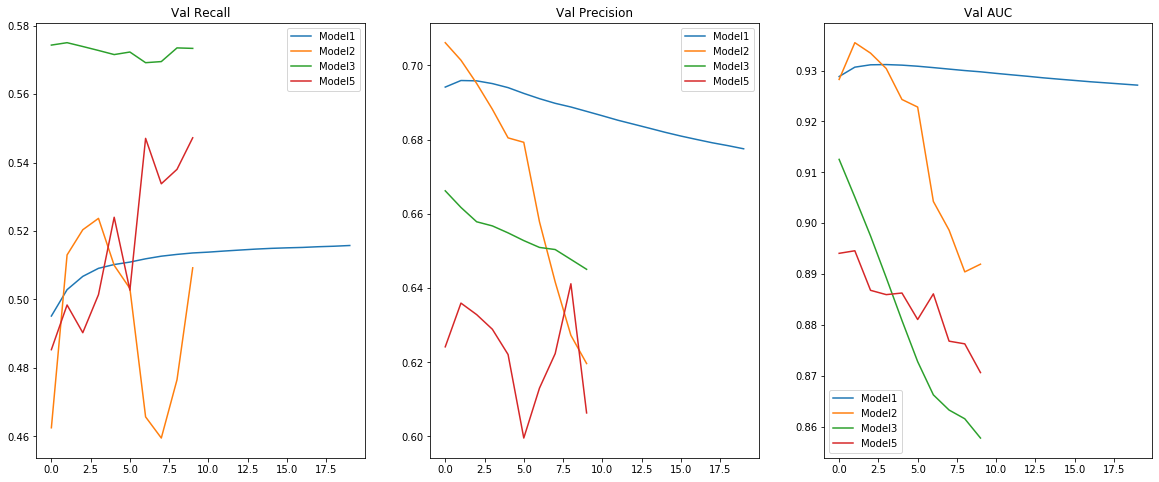

In [21]:
fig, axes = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(8)
axes[0].set_title("Val Recall")
axes[0].plot(history_1['val_recall'], label="Model1")
axes[0].plot(history_2['val_recall'], label="Model2")
axes[0].plot(history_3['val_recall'], label="Model3")
axes[0].plot(history_5['val_recall'], label="Model5")
axes[0].legend()
axes[1].set_title("Val Precision")
axes[1].plot(history_1['val_precision'], label="Model1")
axes[1].plot(history_2['val_precision'], label="Model2")
axes[1].plot(history_3['val_precision'], label="Model3")
axes[1].plot(history_5['val_precision'], label="Model5")
axes[1].legend()
axes[2].set_title("Val AUC")
axes[2].plot(history_1['val_auc'], label="Model1")
axes[2].plot(history_2['val_auc'], label="Model2")
axes[2].plot(history_3['val_auc'], label="Model3")
axes[2].plot(history_5['val_auc'], label="Model5")
axes[2].legend()
fig.show()

## Model 2 filtered_attributes_2_b_model_2020_02_26_13_18_50.h5

In [157]:
model2 = keras.models.load_model('filtered_attributes_2_b_model_2020_02_26_13_18_50.h5')

In [159]:
test_gen.reset()
eval_results2 = model2.evaluate(test_gen)

358/358 [==============================] - 44s 124ms/step - loss: 0.3032 - accuracy: 0.9101 - precision: 0.6075 - recall: 0.4462 - auc: 0.8696


In [182]:
test_gen.reset()
eval_results2 = model2.evaluate(test_gen)

358/358 [==============================] - 44s 122ms/step - loss: 0.3032 - accuracy: 0.9101 - precision: 0.6075 - recall: 0.4462 - auc: 0.8696


In [161]:
test_gen.reset()
preds2 = model2.predict(test_gen)

## Model 3 : filtered_attributes_2_b_model_2020_02_27_12_14_36.h5

### Keras model is throwing error on load with compile=True
- Hence, I loaded the model with compile=False
- I created a new_model with the same layers and configuration as the original model3
- compiled the new_model
- set the weights of new_model with the weights of model3

In [140]:
model3 = keras.models.load_model('filtered_attributes_2_b_model_2020_02_27_12_14_36.h5', compile=False)

In [142]:
base_model = keras.models.load_model('ecom-image-model_basemodel_2020_02_20_20_25_21.h5')
base_model.trainable = True
#logger.info(f"Base Model trainable = {base_model.trainable}")

new_model = keras.models.Sequential()
new_model.add(base_model)
new_model.add(keras.layers.Dense(len(features), activation="sigmoid"))

adam = keras.optimizers.Adam(learning_rate=0.0001)
new_model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy',
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC()
                       ])

In [143]:
new_model.set_weights(model3.get_weights())

In [181]:
test_gen.reset()
eval_results3 = new_model.evaluate(test_gen)

358/358 [==============================] - 44s 122ms/step - loss: 0.5102 - accuracy: 0.9180 - precision: 0.6419 - recall: 0.5233 - auc: 0.8348


In [148]:
test_gen.reset()
preds3 = new_model.predict(test_gen)

### Model 5 : filtered_attributes_5_b_r_model_2020_02_28_01_25_14.h5

In [22]:
model5 = keras.models.load_model('filtered_attributes_6_b_r_d/')

In [23]:
test_gen.reset()
eval_results5 = model5.evaluate(test_gen)

358/358 [==============================] - 46s 128ms/step - loss: 0.3901 - accuracy: 0.9119 - precision: 0.6063 - recall: 0.4978 - auc: 0.8523


In [32]:
test_gen.reset()
preds5 = model5.predict(test_gen)

In [190]:
print("Loss\t\t\tAccuracy   Precision\tRecall\t\tAUC")
print(eval_results2)
print(eval_results3)

Loss			Accuracy   Precision	Recall		AUC
[0.30317845911453556, 0.91013193, 0.60753286, 0.44619834, 0.8696447]
[0.5102039285878229, 0.91796577, 0.64190793, 0.5232613, 0.83481807]


In [34]:
actuals = test_gen.labels

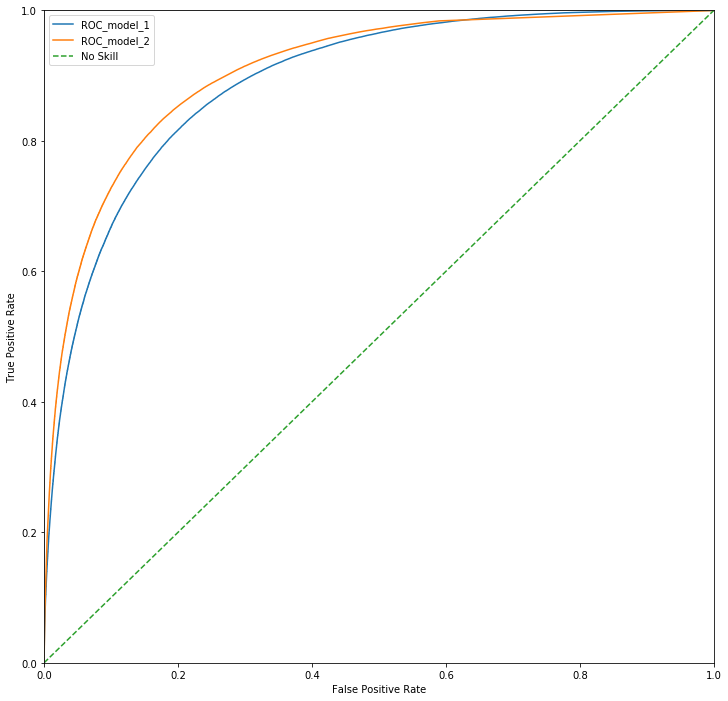

In [164]:
roc_comparison([preds2, preds3], actuals)

## Comparison of Precision and Recalls

In [165]:
classifications2 = result_classifications(actuals, preds2)
classifications3 = result_classifications(actuals, preds3)


In [166]:
pres_recalls2 = calculate_pres_recall(actuals, preds2, classifications2)
pres_recalls3 = calculate_pres_recall(actuals, preds3, classifications3)


In [35]:
classifications5 = result_classifications(actuals, preds5)
pres_recalls5 = calculate_pres_recall(actuals, preds5, classifications5)

In [37]:
def get_pres_recall(pres_recalls_dict):
    precisions = np.nan_to_num([a[0] for a in pres_recalls_dict.values()])
    recalls = np.nan_to_num([a[1] for a in pres_recalls_dict.values()])
    
    return precisions, recalls

In [169]:
precisions2, recalls2 = get_pres_recall(pres_recalls2)
precisions3, recalls3 = get_pres_recall(pres_recalls3)


In [38]:
precisions5, recalls5 = get_pres_recall(pres_recalls5)

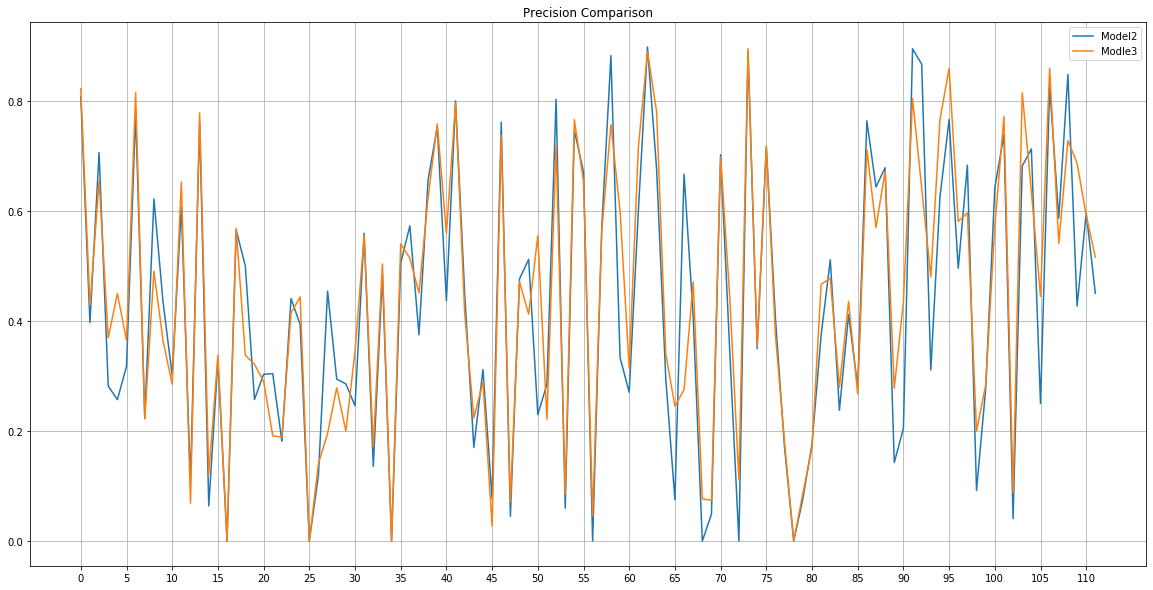

In [244]:
plt.figure(figsize=(20,10))
plt.plot(precisions2, label="Model2")
plt.plot(precisions3, label="Modle3")
plt.grid()
labels = [i for i in range(0,len(precisions2),5)]
plt.xticks(labels)
plt.title("Precision Comparison")
plt.legend()
plt.show()

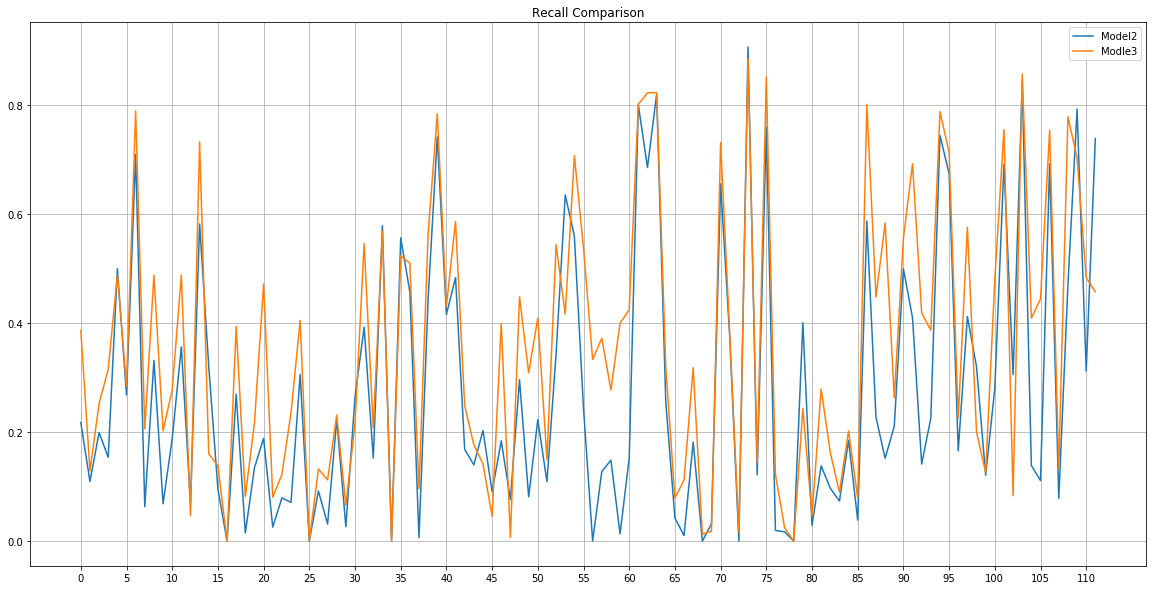

In [245]:
plt.figure(figsize=(20,10))
plt.plot(recalls2, label="Model2")
plt.plot(recalls3, label="Modle3")
plt.grid()
labels = [i for i in range(0,len(recalls2),5)]
plt.xticks(labels)
plt.legend()
plt.title("Recall Comparison")
plt.show()

### F1-Score comparison

In [40]:
def calculate_f1score(prec, recall):
    f1=0.0
    if any([np.isnan(prec), np.isnan(recall)]):
        return f1
    try:
        f1 = 2*prec*recall/(prec+recall)
    except ZeroDivisionError:
        f1=0.0
        
    return f1

In [208]:
model3_f1 = list(map(lambda x: (x[0],calculate_f1score(x[1][0], x[1][1])), pres_recalls3.items()))
model3_f1_sorted = dict(sorted(model3_f1, key=lambda x: x[1], reverse=True))

In [209]:
model2_f1 = list(map(lambda x: (x[0],calculate_f1score(x[1][0], x[1][1])), pres_recalls2.items()))
model2_f1_sorted = dict(sorted(model2_f1, key=lambda x: x[1], reverse=True))

In [41]:
model5_f1 = list(map(lambda x: (x[0],calculate_f1score(x[1][0], x[1][1])), pres_recalls5.items()))
model5_f1_sorted = dict(sorted(model5_f1, key=lambda x: x[1], reverse=True))

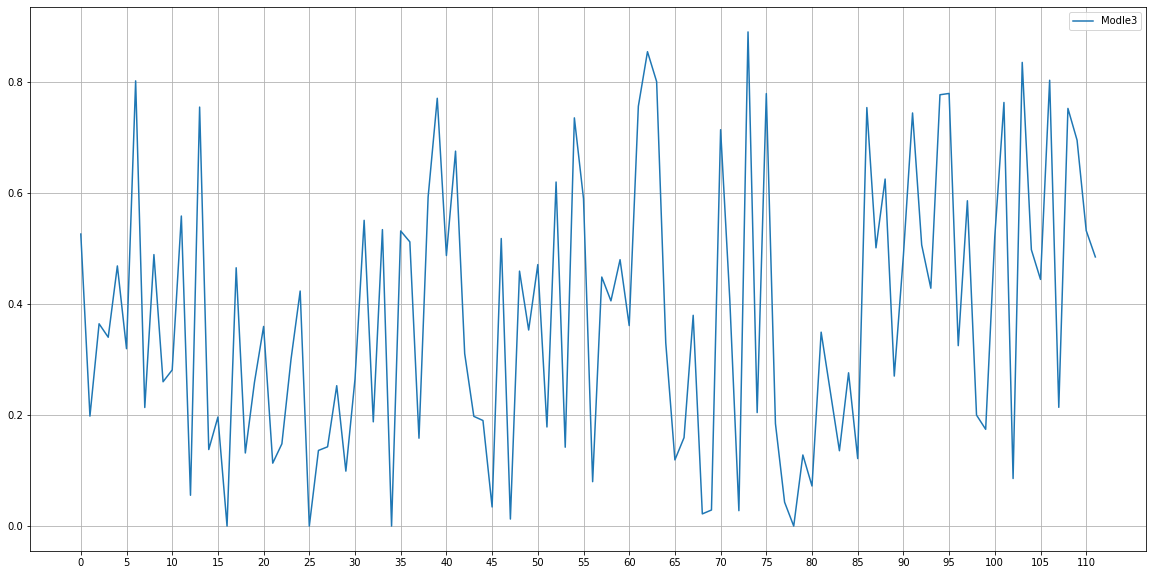

In [213]:
plt.figure(figsize=(20,10))
f1_2 = [a[1] for a in model2_f1]
f1_3 = [a[1] for a in model3_f1]
#plt.plot(f1_2, label="Model2")
plt.plot(f1_3, label="Modle3")
plt.grid()
labels = [i for i in range(0,len(model2_f1),5)]
plt.xticks(labels)
plt.legend()
plt.show()

In [223]:
type(model3_f1_sorted)

dict

In [214]:
model3_f1_sorted

{73: 0.8903821081135292,
 62: 0.8547300332404995,
 103: 0.8354430379746836,
 106: 0.8033081625314635,
 6: 0.8022055373064289,
 63: 0.8008923591745679,
 95: 0.7795163584637268,
 75: 0.779210496550164,
 94: 0.7771428571428572,
 39: 0.7708188031803599,
 101: 0.7632508833922261,
 61: 0.7563788885005243,
 13: 0.754932502596054,
 86: 0.754056633789373,
 108: 0.7525423728813558,
 91: 0.7443365695792881,
 54: 0.7355323394764643,
 70: 0.7141987653247543,
 109: 0.69529499626587,
 41: 0.6755496335776149,
 88: 0.6252676659528907,
 52: 0.6199261992619927,
 38: 0.5930018416206261,
 55: 0.5899893503727369,
 97: 0.5861664712778429,
 11: 0.5586592178770949,
 31: 0.5508909694956206,
 33: 0.5341803356404665,
 110: 0.5324204591220297,
 35: 0.5317436661698957,
 0: 0.5261672095548318,
 100: 0.521978021978022,
 46: 0.5181262729124236,
 36: 0.5120967741935484,
 92: 0.5065789473684211,
 87: 0.5013723696248857,
 104: 0.4979591836734694,
 8: 0.4891566265060241,
 90: 0.4878048780487805,
 40: 0.48749198203976907,


In [215]:
model2_f1_sorted

{73: 0.8980095816664198,
 62: 0.7776360961255518,
 106: 0.7535806096217408,
 103: 0.7529069767441862,
 39: 0.7473909935668335,
 6: 0.7419666586131917,
 63: 0.7408749676417291,
 75: 0.7370001200912694,
 95: 0.7174515235457064,
 101: 0.7148014440433212,
 61: 0.6857142857142857,
 94: 0.6798941798941799,
 70: 0.6781503316138542,
 86: 0.6639892904953145,
 13: 0.659935225757287,
 54: 0.6396593987872533,
 108: 0.6049661399548533,
 41: 0.6027397260273972,
 91: 0.5619834710743802,
 111: 0.5595408895265422,
 109: 0.555026455026455,
 38: 0.5305483028720627,
 35: 0.5295349811478843,
 33: 0.527632183908046,
 97: 0.514367816091954,
 36: 0.5089285714285714,
 52: 0.48108925869894104,
 31: 0.46156552330694817,
 11: 0.4492307692307692,
 8: 0.4326018808777429,
 40: 0.42607683352735737,
 110: 0.4100512163892446,
 100: 0.3901581722319859,
 48: 0.3652694610778443,
 17: 0.3652016311735387,
 71: 0.35913312693498456,
 55: 0.3575498575498575,
 24: 0.3442136498516321,
 0: 0.3428930817610063,
 4: 0.33948339483394

### Top 40 f1-score comparison for Model2 and Model3

In [241]:
f1_df = pd.DataFrame({"model2":[f[1] for f in model2_f1], "model3": [f[1] for f in model3_f1]}, index=[features[f[0]] for f in model2_f1])

In [242]:
xx = f1_df.sort_values('model3', ascending=False).head(40)

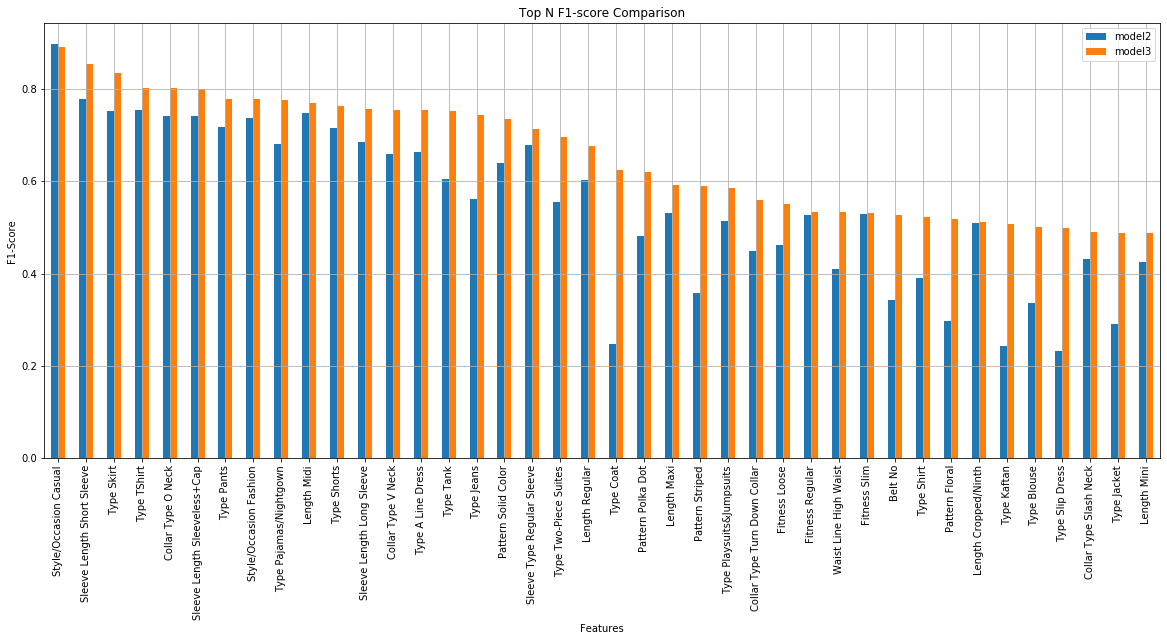

In [248]:
xx.plot(kind='bar', figsize=(20,8), grid=True)
plt.title("Top N F1-score Comparison")
plt.ylabel("F1-Score")
plt.xlabel("Features")
plt.show()